In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import time

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the path to your data directory
data_dir = '/content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data'

In [4]:
# Define image parameters
img_height, img_width = 224, 224
batch_size = 32

#Load and Prepare Dataset

In [5]:
# Create data generators with augmentation for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'Train'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'Validation'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'Test'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

Found 594 files belonging to 4 classes.
Found 86 files belonging to 4 classes.
Found 167 files belonging to 4 classes.


In [6]:
# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Total classes: {num_classes}")

Class names: ['Blix', 'Gian', 'Jerico', 'Jessy']
Total classes: 4


#Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

#Data Pipeline

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

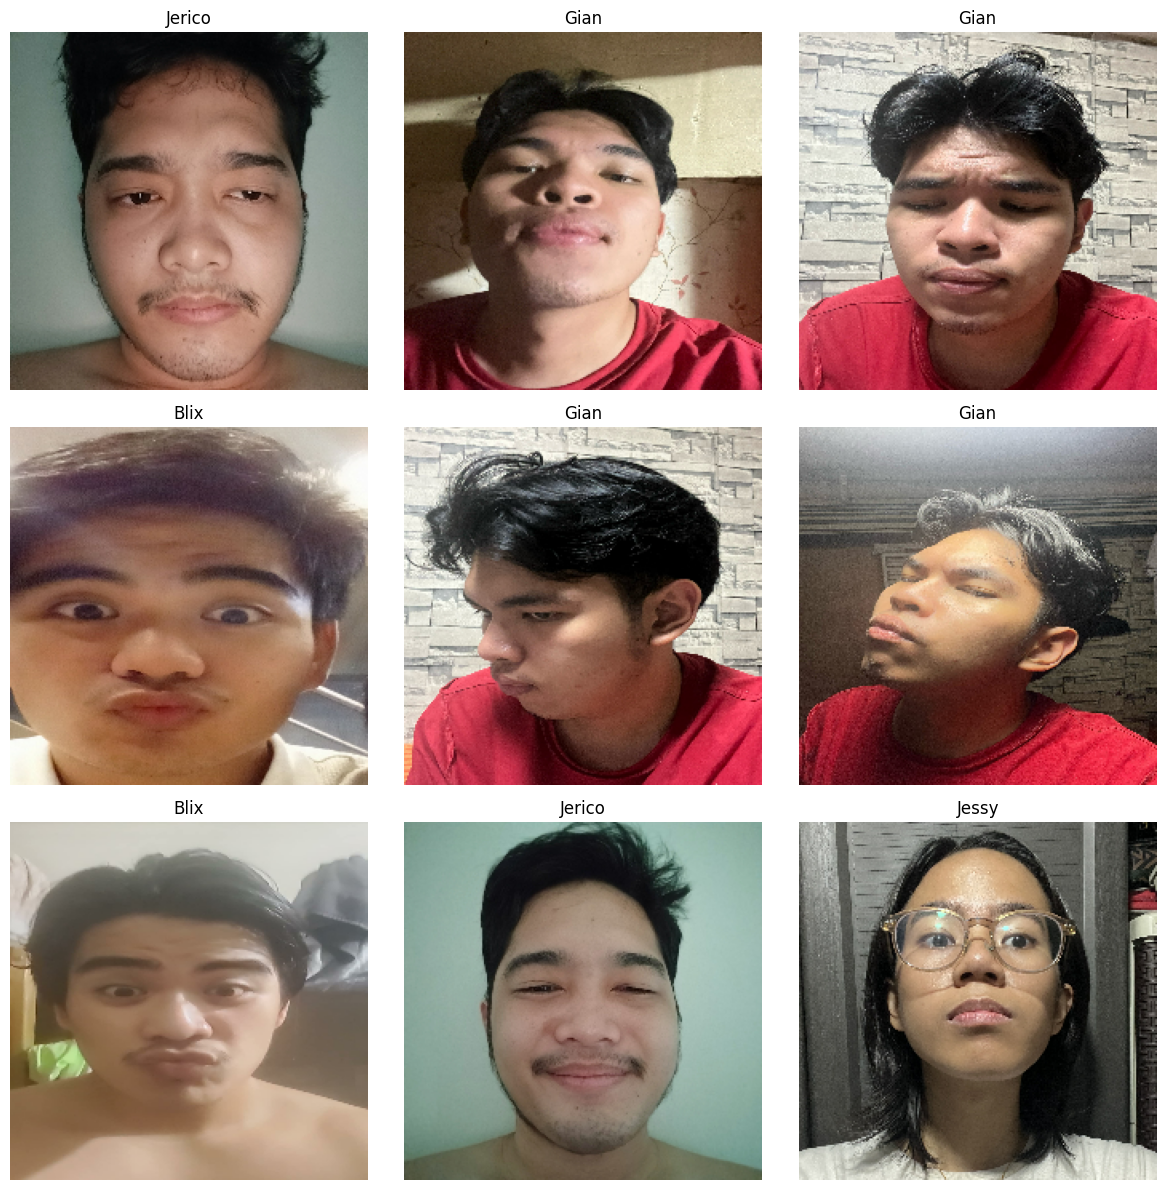

In [9]:
# Visualize some training images
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.savefig('training_samples.png')
plt.show()

In [10]:
# Function to apply data augmentation only to training data
def prepare_for_training(ds, augment=False):
    def augment_map_fn(x, y):
        x = data_augmentation(x)
        return x, y

    if augment:
        ds = ds.map(augment_map_fn, num_parallel_calls=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds, augment=True)

#Model

In [11]:
# Use MobileNetV2 as base model (pretrained on ImageNet)
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Freeze the base model layers initially
base_model.trainable = False

In [13]:
# Create the face recognition model
model = models.Sequential([
    # Preprocessing layer
    layers.Rescaling(1./127.5, offset=-1),

    # Base model
    base_model,

    # Custom classification layers for face recognition
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes)  # Output layer for our 4 people
])

In [14]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(os.path.join(data_dir, 'best_face_model.h5'),
                   monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3901 - loss: 1.7335
Epoch 1: val_accuracy improved from -inf to 0.39535, saving model to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/best_face_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.3974 - loss: 1.7104 - val_accuracy: 0.3953 - val_loss: 1.6480 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8240 - loss: 0.4576
Epoch 2: val_accuracy improved from 0.39535 to 0.41860, saving model to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/best_face_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8244 - loss: 0.4567 - val_accuracy: 0.4186 - val_loss: 1.7539 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8956 - loss: 0.3109
Epoch 3: val_accuracy improved from 0.41860 to 0.44186, saving model to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/best_face_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8960 - loss: 0.3103 - val_accuracy: 0.4419 - val_loss: 1.6876 - learning_rate: 0.0010
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9165 - loss: 0.2571
Epoch 4: val_accuracy improved from 0.44186 to 0.45349, saving model to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/best_face_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9169 - loss: 0.2560 - val_accuracy: 0.4535 - val_loss: 1.5741 - learning_rate: 0.0010
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9216 - loss: 0.2506
Epoch 5: val_accuracy improved from 0.45349 to 0.52326, saving model to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/best_face_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9223 - loss: 0.2482 - val_accuracy: 0.5233 - val_loss: 1.4196 - learning_rate: 0.0010
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9295 - loss: 0.2001
Epoch 6: val_accuracy improved from 0.52326 to 0.54651, saving model to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/best_face_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9299 - loss: 0.2000 - val_accuracy: 0.5465 - val_loss: 1.4600 - learning_rate: 0.0010
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9578 - loss: 0.1401
Epoch 7: val_accuracy did not improve from 0.54651
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9576 - loss: 0.1409 - val_accuracy: 0.5000 - val_loss: 1.4594 - learning_rate: 0.0010
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9300 - loss: 0.1668
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 8: val_accuracy did not improve from 0.54651
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9302 - loss: 0.1669 - val_accuracy: 0.4767 - val_loss: 1.4927 - learning_rate: 0.0010
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9450 - loss: 0.1247
Epoch 9: val_accuracy did not improve from 0.54651
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9449 - loss: 0.1249 - val_accuracy: 0.4884 - val_l

#Evaluate

In [18]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.5682 - loss: 1.1705
Test accuracy: 0.5749


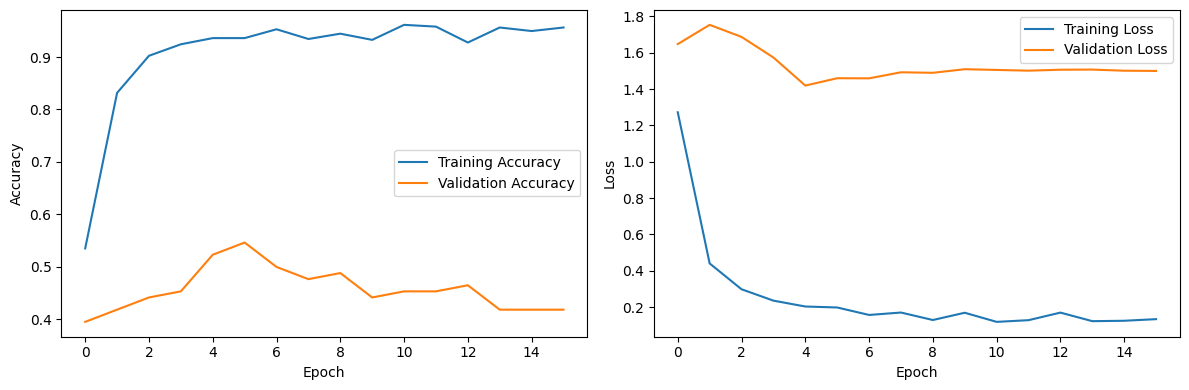

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [20]:
if test_accuracy < 0.95:
    print("Fine-tuning the model for better accuracy...")

    # Unfreeze the top layers of the base model
    base_model.trainable = True

    # Freeze first 100 layers
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Recompile with lower learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Fine-tune the model
    fine_tune_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=callbacks
    )

    # Re-evaluate
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test accuracy after fine-tuning: {test_accuracy:.4f}")

Fine-tuning the model for better accuracy...
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8459 - loss: 0.5658
Epoch 1: val_accuracy did not improve from 0.54651
19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.8478 - loss: 0.5564 - val_accuracy: 0.2907 - val_loss: 2.5107 - learning_rate: 1.0000e-04
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9531 - loss: 0.1349
Epoch 2: val_accuracy did not improve from 0.54651
19/19 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9537 - loss: 0.1336 - val_accuracy: 0.3488 - val_loss: 2.9879 - learning_rate: 1.0000e-04
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9654 - loss: 0.0791
Epoch 3: val_accuracy did not improve from 0.54651
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9657 - loss: 0.0788 - val_accuracy: 0.4186 - val_loss: 3.2554 - learning_rate: 1.0000e-04
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9785 - loss: 0.0610
Epoch 4: ReduceLROnPlateau reducing learn

#Save model

In [29]:
# Save the final model with .keras extension
model.save(os.path.join(data_dir, 'face_recognition_model.keras'))
print(f"Model saved to {os.path.join(data_dir, 'face_recognition_model.keras')}")

Model saved to /content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/face_recognition_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


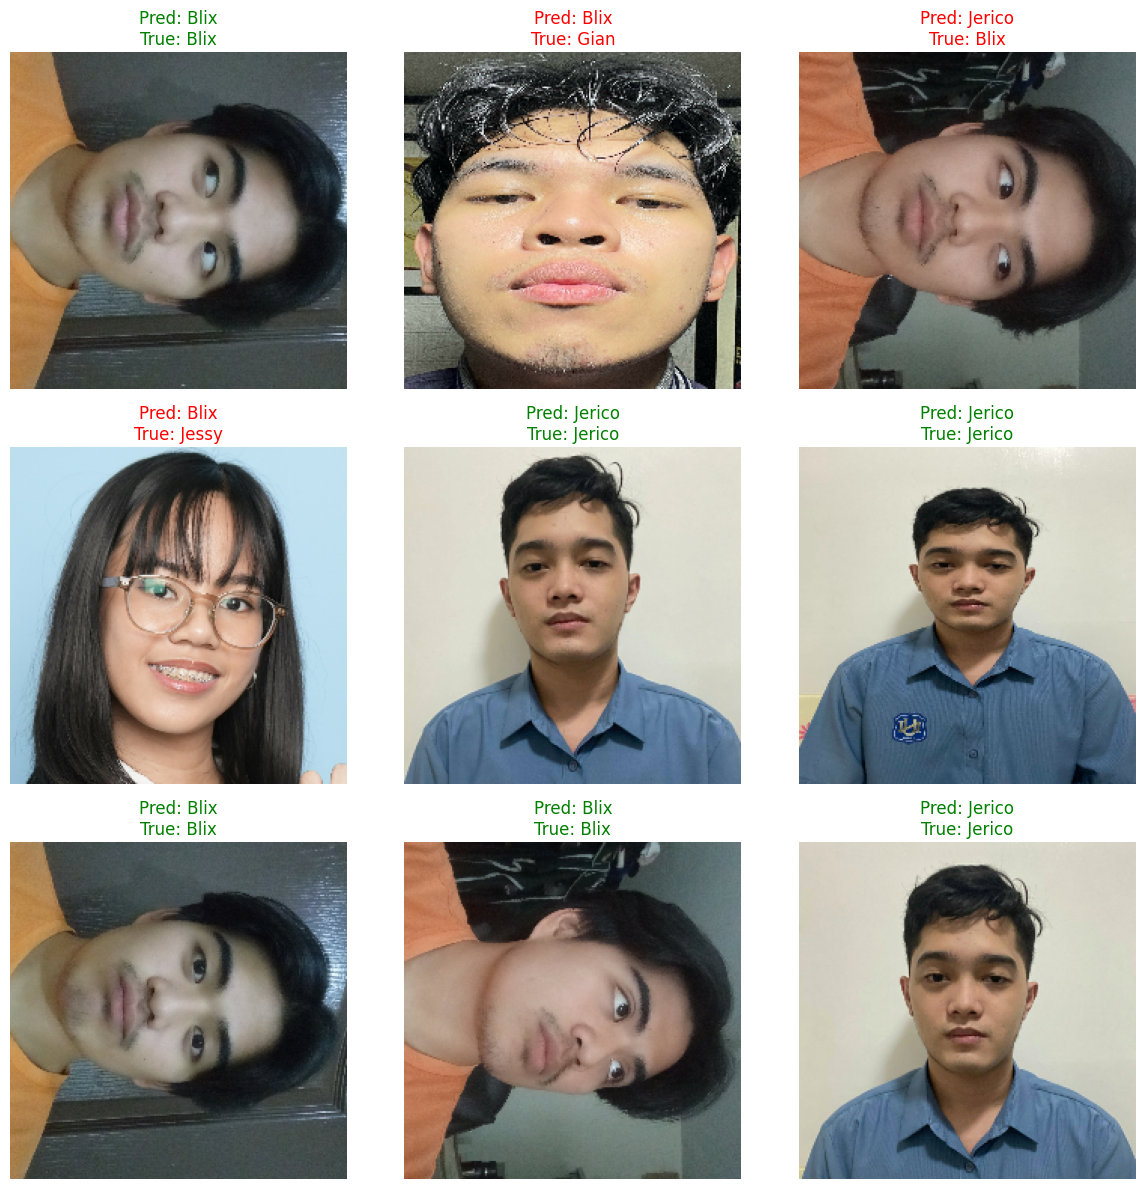

In [23]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    predictions = model.predict(images)

    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_index = np.argmax(predictions[i])
        true_index = labels[i].numpy()

        color = "green" if predicted_index == true_index else "red"
        plt.title(f"Pred: {class_names[predicted_index]}\nTrue: {class_names[true_index]}",
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.savefig('prediction_samples.png')
plt.show()

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpixg25zby'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139279418041808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418043344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418042192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418042384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418043728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418044688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418046032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418046416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418046224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279418044880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1392794180

In [25]:
with open(os.path.join(data_dir, "face_recognition_model.tflite"), 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved as 'face_recognition_model.tflite'")

TFLite model saved as 'face_recognition_model.tflite'


#Camera Test

In [26]:
import cv2
import numpy as np
import tensorflow as tf
import time
import os
from google.colab.patches import cv2_imshow  # For displaying images in Colab

In [31]:
# Load the model
model_path = '/content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data/face_recognition_model'  # Update this path if necessary
model_path = model_path + ".keras" # Add the .keras extension
model = tf.keras.models.load_model(model_path)

In [33]:
# Get class names (replace with the actual path to your training data)
data_dir = '/content/drive/MyDrive/CCDEPLRL_MidtermsP2_Data'
class_names = os.listdir(os.path.join(data_dir, 'Train'))
print(f"Class names: {class_names}")

Class names: ['Blix', 'Gian', 'Jerico', 'Jessy']


In [34]:
# Load the face detector (using Haar Cascade for simplicity)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [35]:
def preprocess_face(face_img):
    """Preprocess the face image for the model"""
    # Resize to the input shape expected by the model
    resized = cv2.resize(face_img, (224, 224))
    # Convert to RGB (OpenCV uses BGR)
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    # Normalize pixel values
    normalized = rgb / 127.5 - 1
    # Expand dimensions for batch input
    expanded = np.expand_dims(normalized, axis=0)
    return expanded

In [36]:
def recognize_face(face_img):
    """Run face recognition on a single face image"""
    # Preprocess the face
    processed_face = preprocess_face(face_img)

    # Get model prediction
    predictions = model.predict(processed_face)
    predicted_class = np.argmax(predictions[0])
    confidence = tf.nn.softmax(predictions[0]).numpy()[predicted_class]

    return predicted_class, confidence

In [37]:
# For Colab with webcam
def run_webcam_recognition_colab():
    """Simulate webcam in Colab by capturing frames from webcam upload"""
    print("Upload a photo with faces to recognize:")

    # This would normally be a video capture loop
    # For Colab, we'll use a placeholder image upload approach
    # Upload an image or use a test image from your dataset

    from google.colab import files
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Read the image
        img = cv2.imread(filename)

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Process each detected face
        for (x, y, w, h) in faces:
            # Extract face region
            face_img = img[y:y+h, x:x+w]

            # Recognize the face
            predicted_class, confidence = recognize_face(face_img)

            # Format confidence as percentage
            confidence_pct = confidence * 100

            # Draw rectangle around face and label
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = f"{class_names[predicted_class]} ({confidence_pct:.2f}%)"
            cv2.putText(img, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Display the result
        cv2_imshow(img)

    print("Face recognition complete.")

In [38]:
def run_webcam_recognition():
    """Run face recognition on webcam feed (use this when NOT in Colab)"""
    # Initialize webcam
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print("Face recognition started. Press 'q' to quit.")

    while True:
        # Read frame from webcam
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image")
            break

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Process each detected face
        for (x, y, w, h) in faces:
            # Extract face region
            face_img = frame[y:y+h, x:x+w]

            # Recognize the face
            predicted_class, confidence = recognize_face(face_img)

            # Format confidence as percentage
            confidence_pct = confidence * 100

            # Draw rectangle around face and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = f"{class_names[predicted_class]} ({confidence_pct:.2f}%)"
            cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Display the result
        cv2.imshow('Face Recognition', frame)

        # Exit if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

Upload a photo with faces to recognize:


Saving Jerico C. Lim_2022-102256.png to Jerico C. Lim_2022-102256.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


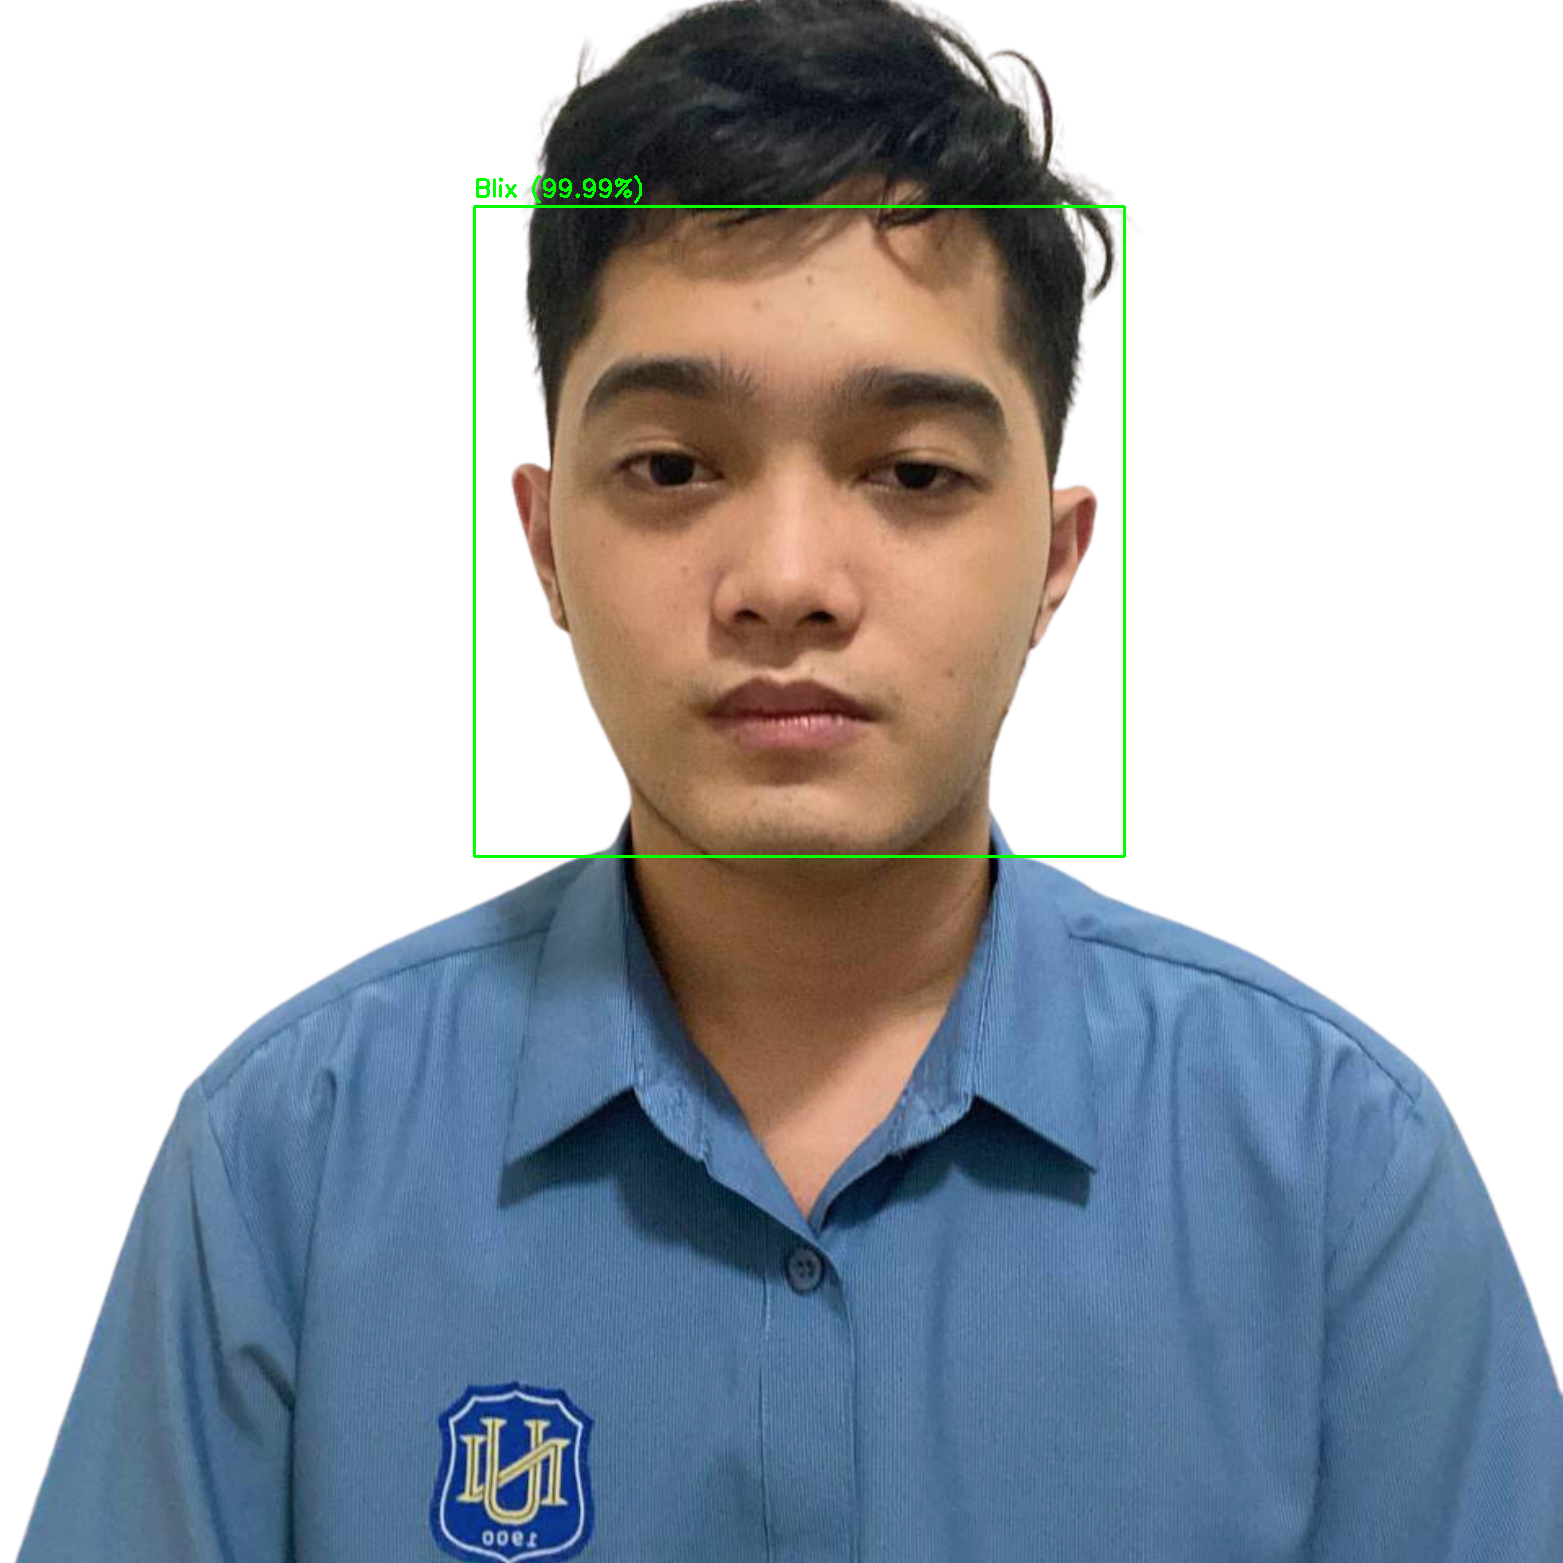

Face recognition complete.


In [44]:
# Determine if we're in Colab or not
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if __name__ == "__main__":
    if IN_COLAB:
        run_webcam_recognition_colab()
    else:
        run_webcam_recognition()